In [1]:
import pandas as pd , numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from bayes_opt import BayesianOptimization
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from IPython.display import clear_output
import collections, os
import pickle
from sklearn.manifold import TSNE
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler , StandardScaler , MinMaxScaler , Normalizer
import sys
sys.path.append('/home/advice/Python/SR/Custom/')
from IPython.display import display, Image

from cat_num_corrplot import *
from Init import *
from CompressData import *
from visualization import *
from utility import * 
from BayesOpt import Opt


    사용하면 좋은 패키지
    train_validation_test_split / cat2dict / code2cat / colorlist / onehotencoding / roccurve  / ProbDensity
    pycm import *  
    ConfusionMatrix(actual_vector=``test_y``, predict_vector= ``pred`` ) 
    사용하면 통계량값 다 얻을 수 있음
    


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
df = pd.read_csv("/home/advice/Python/SR/Data/Rain/GAIN_Data.csv")
df = df.sample(frac=1).reset_index(drop=True)
#print(df.columns)

label = df["RainTomorrow"]
Input = df.drop(['Date', 'Location' , 'RainTomorrow' , "RISK_MM"], axis = 1)

# one_hot_category = pd.get_dummies(Input.select_dtypes("object") , drop_first = False)
# numeirc_input = Input.drop(columns= Input.select_dtypes("object").columns)
object_list = Input.select_dtypes("object").columns.tolist()
one_hot_category = onehotencoding(Input[object_list] , object_list)
numeirc_input = Input.drop(columns= object_list )
#scaler = RobustScaler()
#scaler = MinMaxScaler(feature_range=(-1,1))
scaler = Normalizer()
numeirc_input = pd.DataFrame( scaler.fit_transform(numeirc_input.values), 
                            columns = numeirc_input.columns)
Input = pd.concat([one_hot_category , numeirc_input ] , axis = 1)

In [3]:
Input.head()

,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,...,Rainfall,Evaporation,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0.936494,-1.209184,-0.8125,0.038462,-0.793103,-68.714392,-41.562161,0.397849,0.816327
1,0,0,0,0,0,0,1,0,0,0,...,5.250000,-0.058337,-0.291357,-0.4375,1.038462,0.862069,-0.055559,0.275229,-0.935484,-1.020408
2,0,0,0,0,1,0,0,0,0,0,...,0.000000,0.980556,0.760499,0.8125,0.461538,1.068966,-0.370371,-0.302750,0.483871,-0.010204
3,0,0,0,0,0,0,1,0,0,0,...,57.249998,0.876326,0.684304,0.4375,1.038462,1.620690,-0.620372,-0.403671,0.247312,-0.377551
4,1,0,0,0,0,0,0,0,0,0,...,0.000000,-0.010209,0.422928,-0.5625,-0.230769,0.000000,0.435187,0.458715,0.827957,0.438775


In [5]:
x_data = Input.values
y_data = LabelEncoder().fit_transform(label)
onehot = pd.get_dummies(label).values
x_train, x_test, y_train, y_test ,  y_train_label, y_test_label =\
train_test_split(x_data, onehot, y_data, test_size = 0.3)
x_train, x_valid, y_train, y_valid ,  y_train_label, y_valid_label =\
train_test_split(x_train, y_train, y_train_label, test_size = 0.1)

In [6]:
x_train.shape , x_valid.shape , x_test.shape , y_train.shape

((89581, 66), (9954, 66), (42658, 66), (89581, 2))

In [7]:
active_dict = {0: "leaky_relu" , 1 : "relu" , 2 : "elu", 3 : "relu6" , 4 : "selu"}

In [8]:
accbest = 0.75
Bayes_iter = 1

Save_dir = "./OptMMTest"
if tf.gfile.Exists(Save_dir):
    tf.gfile.DeleteRecursively(Save_dir)
    tf.gfile.MakeDirs(Save_dir)
    tf.gfile.MakeDirs(Save_dir + "/Plot")
else :
    tf.gfile.MakeDirs(Save_dir)
    tf.gfile.MakeDirs(Save_dir + "/Plot")
    
log_file = open(Save_dir + '/Report_Bayesopt_Parm.log', 'a')
reportdir = Save_dir + "/Report_Opt.txt"
epoch_n = 1000 
batch_size = 512

Op = Opt(accbest = accbest , Bayes_iter= Bayes_iter ,
         epoch_n = epoch_n , batch_size = batch_size , 
         x_train = x_train , y_train = y_train , 
         x_valid=  x_valid, y_valid= y_valid ,
         x_test =  x_test , y_test= y_test ,
         log_file= log_file  , reportdir = reportdir)

In [9]:
first_layer = np.shape(x_data)[1]
NN_BAYESIAN = BayesianOptimization(Op.generate_nn, 
                              {'num_hidden': (4, 9),
                               'size_layer': ( first_layer -10 ,first_layer +20 ),
                               'learning_rate': (0.01, 0.001),
                               'dropout_rate': (0.01, 0.3),
                               'activation': (0, 4),
                               "reduction_node" : (9 , 15 )
                              })
NN_BAYESIAN.maximize(init_points = 10 , n_iter = 200 , acq="ei", xi=0.5 )

|   iter    |  target   | activa... | dropou... | learni... | num_hi... | reduct... | size_l... |
-------------------------------------------------------------------------------------------------
Epoch N : 1000 , Batch Interation N : 174

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



IndexError: tuple index out of range

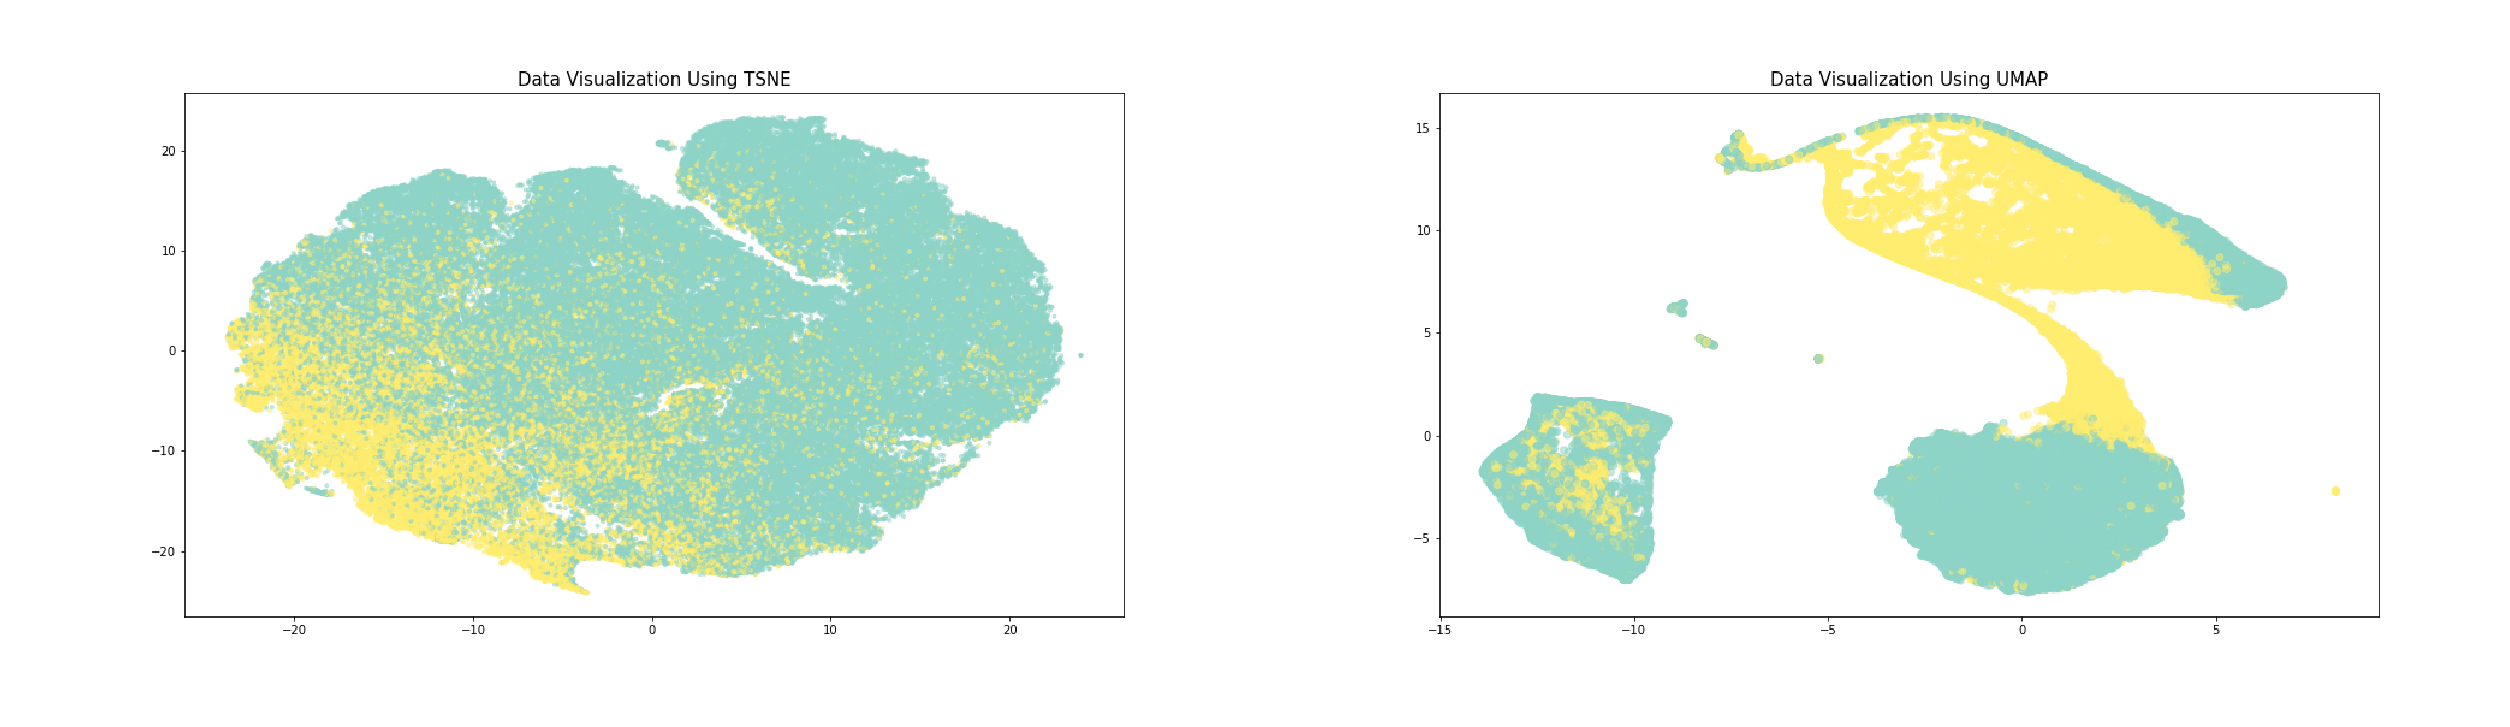

In [52]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
tsneimg=mpimg.imread('RAIN_TSNE.png')
umapimg=mpimg.imread('RAIN_UMAP.png')
fig, (ax0, ax1) = plt.subplots(1, 2 , figsize = (35, 35))
ax0.imshow(tsneimg)
ax0.axis('off')
ax1.imshow(umapimg)
ax1.axis('off')
plt.tight_layout()
plt.show()

In [43]:
y_test

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

In [30]:
with open("./OptTest/57_test_result.p", "rb") as f :
    dd = pickle.load(f)

rainidx = y_test[:,1] == 1   
print(dd[0])
np.bincount(y_test[:,0])

0.8416241


array([ 9549, 33109])

In [32]:
print(y_test)

[[1 0]
 [1 0]
 [0 1]
 ...
 [0 1]
 [1 0]
 [0 1]]


(array([3.412e+04, 1.100e+01, 4.000e+00, 5.000e+00, 3.000e+00, 3.000e+00,
        2.000e+00, 3.000e+00, 4.000e+00, 8.503e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

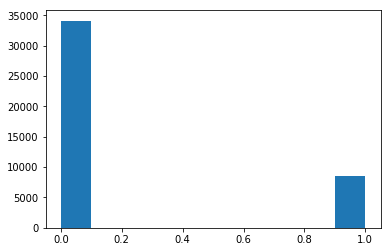

In [34]:
plt.hist(dd[1][:, 1])

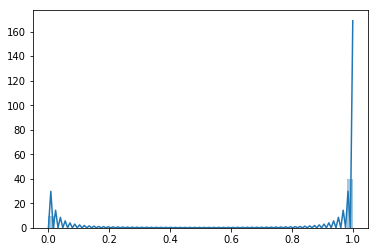

In [12]:
#plt.hist(dd[1][:,1])
sns.distplot(dd[1][:,0])

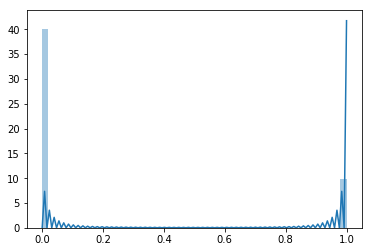

In [13]:
#sns.distplot(dd[1][:,1][rainidx])
sns.distplot(dd[1][:,1][~rainidx])

In [20]:
dd[1][:,1][rainidx]

array([0.0000000e+00, 2.6453469e-28, 0.0000000e+00, ..., 1.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [15]:
pred = np.argmax(dd[1], axis = 1)
true = np.argmax(y_test, axis = 1)
from pycm import *
cm = ConfusionMatrix(actual_vector=true, predict_vector=pred)
print(cm)

Predict     0           1           
Actual
0           26536       6573        

1           7607        1942        





Overall Statistics : 

95% CI                                                            (0.66312,0.67206)
AUNP                                                              0.50242
AUNU                                                              0.50242
Bennett S                                                         0.33518
CBA                                                               0.49029
Chi-Squared                                                       1.08939
Chi-Squared DF                                                    1
Conditional Entropy                                               0.72113
Cramer V                                                          0.00505
Cross Entropy                                                     0.76971
Gwet AC1                                                          0.50103
Hamming Loss                       

In [24]:
dd[1][rainidx,1].shape , dd[1][~rainidx,1].shape

((9549,), (33109,))

(array([7.602e+03, 1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 1.938e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

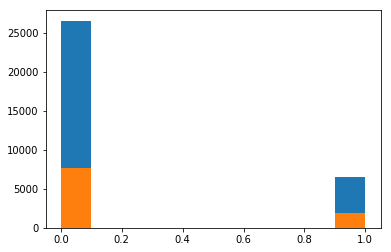

In [28]:
plt.hist(dd[1][~rainidx,1])
plt.hist(dd[1][rainidx,1])

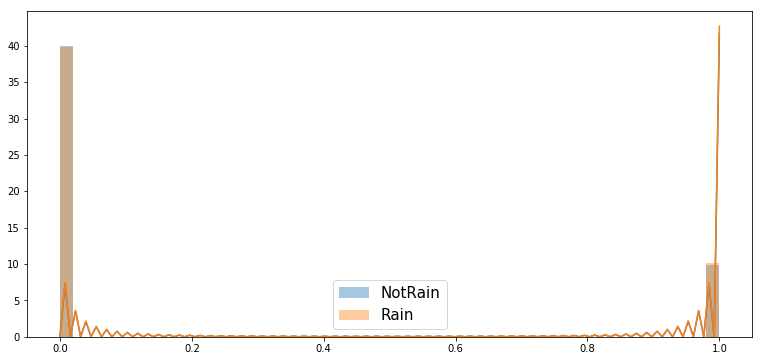

In [25]:
import seaborn as sns
f, ax = plt.subplots(figsize=(13,6))
sns.distplot(dd[1][:,1][~rainidx] , label ="NotRain")
sns.distplot(dd[1][:,1][rainidx] , label ="Rain")
plt.legend(fontsize= 15)
#plt.savefig("./OptTest/Plot/{}.png".format(self.Bayes_iter))
plt.show()

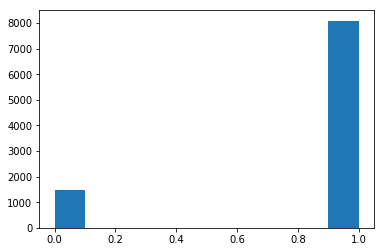

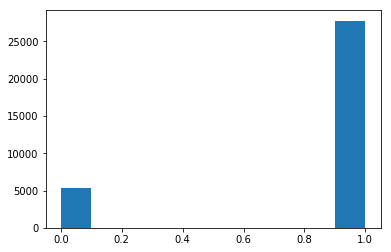

In [168]:
plt.hist(dd[1][rainidx,0])
plt.show()
plt.hist(dd[1][~rainidx,0])
plt.show()